In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

basedir = Path("../analysis/stratification_base_quality/quals")

In [86]:
file

PosixPath('../analysis/stratification_base_quality/quals/xplus_sns_MM1S_g4_forward.tsv')

In [131]:
data = []
maxq = 0
for file in basedir.rglob("*.tsv"):
    df = pd.read_csv(file, sep="\t")

    maxq = max(max(df.columns[3:].values.astype(int)), maxq)
    
    sequencer, source, cell, _,readdirection = file.stem.split("_")

    df["file"] = file.stem
    df["run"] = sequencer + "_" + source
    df["cell"] = cell
    df["rfwd"] = readdirection == "forward"
    data.append(df)

data = pd.concat(data)
quals = [str(i) for i in range(1, maxq+1)]
quals_int = np.arange(1, maxq+1)
data = data.groupby(["run", "cell", "pos", "ss"])[quals + ["bases"]].sum().reset_index()
data["AverageQ"] = data[quals].dot(quals_int) / data[quals].sum(axis=1)

# Convert to probabilities
probs = 10 ** (-quals_int / 10)

data["AveragePQ"] = data[quals].dot(probs) / data[quals].sum(axis=1)
data["AveragePQ"] = -10 * np.log10(data["AveragePQ"])

data["Bases"] = data[quals].sum(axis=1)
data["Bases"] = data["Bases"].astype(int)

# Bin the quality scores to match Illumina
binnedQ = {
    0: (min(quals_int),2),
    12: (3, 17),
    24: (18, 30),
    40: (31, maxq),
}
binnedQ_keys = list(binnedQ.keys())
binnedQ_labels = [f"bin_{q}" for q in binnedQ_keys]
binnedQ_probs = [10 ** (-q / 10) for q in binnedQ_keys]

for q, (low, high) in binnedQ.items():
    qcols = [str(i) for i in range(low, high+1)]
    data["bin_" + str(q)] = data[quals].loc[:, qcols].sum(axis=1)

data["AverageQbin"] = data[binnedQ_labels].dot(binnedQ_keys) / data[binnedQ_labels].sum(axis=1)
data["AveragePQbin"] = data[binnedQ_labels].dot(binnedQ_probs) / data[binnedQ_labels].sum(axis=1)
data["AveragePQbin"] = -10 * np.log10(data["AveragePQbin"])
data


,run,cell,pos,ss,1,2,3,4,5,6,...,bases,AverageQ,AveragePQ,Bases,bin_0,bin_12,bin_24,bin_40,AverageQbin,AveragePQbin
0,aviti_hq,KMS12BM,-150,False,0,0,0,0,0,0,...,65,40.476923,39.299578,65,0,0,0,65.0,40.000000,40.000000
1,aviti_hq,KMS12BM,-150,True,0,0,0,0,0,1,...,56,38.571429,23.159572,56,0,1,2,53.0,38.928571,28.653342
2,aviti_hq,KMS12BM,-149,False,0,0,0,0,0,1,...,1766,37.246886,33.517379,1766,0,5,10,1751.0,39.830125,35.223959
3,aviti_hq,KMS12BM,-149,True,0,0,0,0,0,0,...,1811,36.843181,32.427535,1811,0,9,32,1770.0,39.578134,33.172745
4,aviti_hq,KMS12BM,-148,False,0,0,0,0,0,0,...,5094,38.132928,35.312528,5093,0,8,44,5041.0,39.817789,36.336099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7219,xplus_sns,REH,148,True,0,0,0,0,0,0,...,3082,38.438676,26.774201,3082,0,89,145,2848.0,38.438676,26.774201
7220,xplus_sns,REH,149,False,0,0,0,0,0,0,...,1240,37.709677,24.835378,1240,0,58,76,1106.0,37.709677,24.835378
7221,xplus_sns,REH,149,True,0,0,0,0,0,0,...,1121,38.322926,26.966051,1121,0,30,65,1026.0,38.322926,26.966051
7222,xplus_sns,REH,150,False,0,0,0,0,0,0,...,77,34.389610,21.366618,77,0,8,13,56.0,34.389610,21.366618


In [98]:
probs

array([7.94328235e-01, 6.30957344e-01, 5.01187234e-01, 3.98107171e-01,
       3.16227766e-01, 2.51188643e-01, 1.99526231e-01, 1.58489319e-01,
       1.25892541e-01, 1.00000000e-01, 7.94328235e-02, 6.30957344e-02,
       5.01187234e-02, 3.98107171e-02, 3.16227766e-02, 2.51188643e-02,
       1.99526231e-02, 1.58489319e-02, 1.25892541e-02, 1.00000000e-02,
       7.94328235e-03, 6.30957344e-03, 5.01187234e-03, 3.98107171e-03,
       3.16227766e-03, 2.51188643e-03, 1.99526231e-03, 1.58489319e-03,
       1.25892541e-03, 1.00000000e-03, 7.94328235e-04, 6.30957344e-04,
       5.01187234e-04, 3.98107171e-04, 3.16227766e-04, 2.51188643e-04,
       1.99526231e-04, 1.58489319e-04, 1.25892541e-04, 1.00000000e-04,
       7.94328235e-05, 6.30957344e-05, 5.01187234e-05, 3.98107171e-05,
       3.16227766e-05])

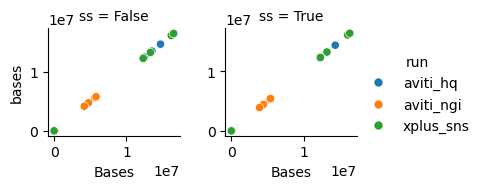

In [90]:
sns.relplot(
    x="Bases",
    y="bases",
    hue="run",
    col="ss",
    data=data,
    height=2,
    facet_kws={"sharey": False},
)

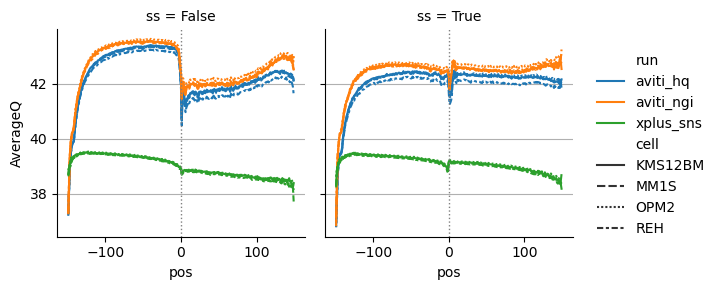

In [101]:
d = data.query("pos < 150 & pos > -150")
g = sns.relplot(
    x="pos",
    y="AverageQ",
    hue="run",
    col="ss",
    data=d,
    height=3,
    kind="line",
    style="cell",
    facet_kws={"sharey": True},
)
g.refline(x=0, linestyle=":", linewidth=1)
# add grid
for ax in g.axes.flat:
    ax.grid(True, axis="y")


/var/folders/9f/8ggsf77s7hx0xcdvhzs8pfjx0t5xky/T/ipykernel_73193/396815986.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["AveragePQ_smooth"] = d.groupby(["run", "ss", "cell"])["AveragePQ"].transform(


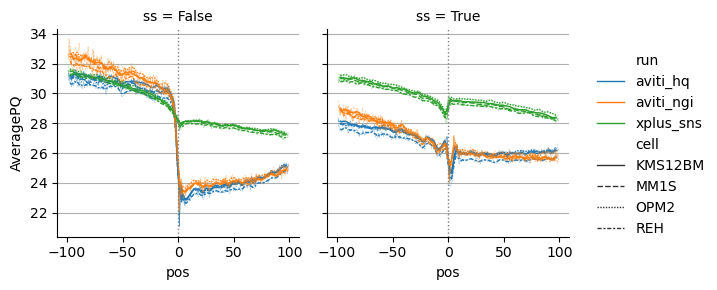

In [129]:
d = data.query("pos < 100 & pos > -100")
d["AveragePQ_smooth"] = d.groupby(["run", "ss", "cell"])["AveragePQ"].transform(
    lambda x: x.rolling(5, center=True).mean()
)
g = sns.relplot(
    x="pos",
    y="AveragePQ_smooth",
    hue="run",
    col="ss",
    data=d,
    height=3,
    kind="line",
    style="cell",
    lw=1,
    facet_kws={"sharey": True},
)
g.map_dataframe(
    sns.lineplot,
    data=d,
    x="pos",
    y="AveragePQ",
    hue="run",
    lw=0.5,
    alpha=0.5,
    style="cell",
)
g.refline(x=0, linestyle=":", linewidth=1)
# add grid
for ax in g.axes.flat:
    ax.grid(True, axis="y")


/var/folders/9f/8ggsf77s7hx0xcdvhzs8pfjx0t5xky/T/ipykernel_73193/4257760093.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["AveragePQ_smooth"] = d.groupby(["run", "ss", "cell"])["AveragePQbin"].transform(


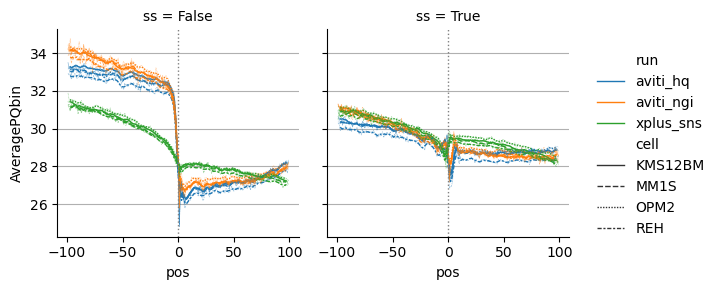

In [132]:
d = data.query("pos < 100 & pos > -100")
d["AveragePQ_smooth"] = d.groupby(["run", "ss", "cell"])["AveragePQbin"].transform(
    lambda x: x.rolling(5, center=True).mean()
)
g = sns.relplot(
    x="pos",
    y="AveragePQ_smooth",
    hue="run",
    col="ss",
    data=d,
    height=3,
    kind="line",
    style="cell",
    lw=1,
    facet_kws={"sharey": True},
)
g.map_dataframe(
    sns.lineplot,
    data=d,
    x="pos",
    y="AveragePQbin",
    hue="run",
    lw=0.5,
    alpha=0.5,
    style="cell",
)
g.refline(x=0, linestyle=":", linewidth=1)
# add grid
for ax in g.axes.flat:
    ax.grid(True, axis="y")


/var/folders/9f/8ggsf77s7hx0xcdvhzs8pfjx0t5xky/T/ipykernel_73193/3962961974.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["AverageQ_smooth"] = d.groupby(["run", "ss", "cell"])["AverageQbin"].transform(


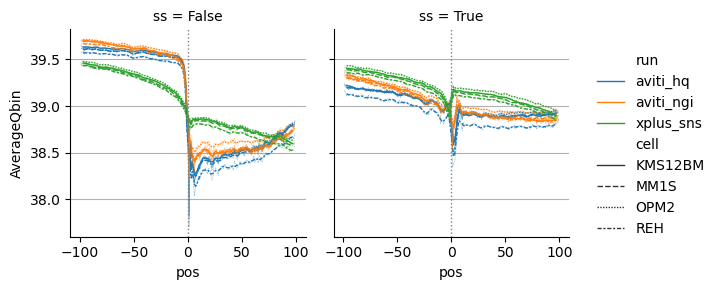

In [134]:
d = data.query("pos < 100 & pos > -100")
d["AverageQ_smooth"] = d.groupby(["run", "ss", "cell"])["AverageQbin"].transform(
    lambda x: x.rolling(5, center=True).mean()
)
g = sns.relplot(
    x="pos",
    y="AverageQ_smooth",
    hue="run",
    col="ss",
    data=d,
    height=3,
    kind="line",
    style="cell",
    lw=1,
    facet_kws={"sharey": True},
)
g.map_dataframe(
    sns.lineplot,
    data=d,
    x="pos",
    y="AverageQbin",
    hue="run",
    lw=0.5,
    alpha=0.5,
    style="cell",
)
g.refline(x=0, linestyle=":", linewidth=1)
# add grid
for ax in g.axes.flat:
    ax.grid(True, axis="y")


/var/folders/9f/8ggsf77s7hx0xcdvhzs8pfjx0t5xky/T/ipykernel_73193/1640144826.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["AverageQ_smooth"] = d.groupby(["run", "ss", "cell"])["AverageQ"].transform(


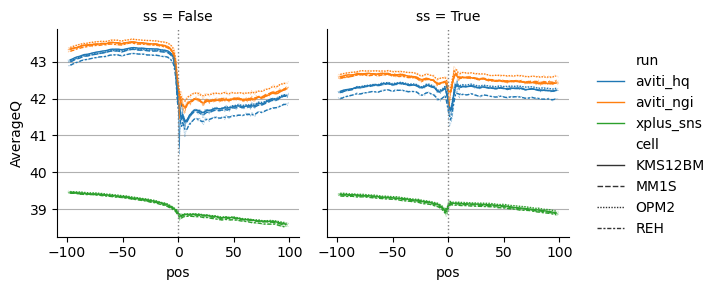

In [118]:
d = data.query("pos < 100 & pos > -100")
d["AverageQ_smooth"] = d.groupby(["run", "ss", "cell"])["AverageQ"].transform(
    lambda x: x.rolling(5, center=True).mean()
)
g = sns.relplot(
    x="pos",
    y="AverageQ_smooth",
    hue="run",
    col="ss",
    data=d,
    height=3,
    kind="line",
    style="cell",
    lw=1,
    facet_kws={"sharey": True},
)
g.map_dataframe(
    sns.lineplot,
    data=d,
    x="pos",
    y="AverageQ",
    hue="run",
    lw=0.5,
    alpha=0.5,
    style="cell",
)
g.refline(x=0, linestyle=":", linewidth=1)
# add grid
for ax in g.axes.flat:
    ax.grid(True, axis="y")


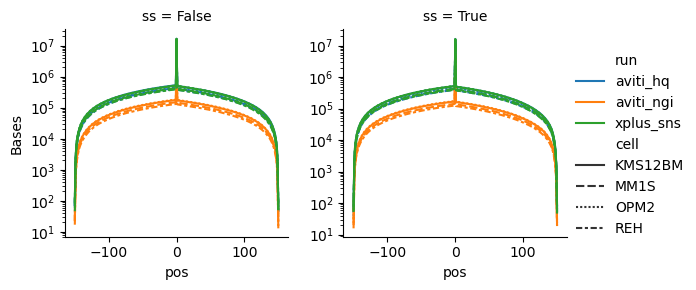

In [121]:
g = sns.relplot(
    x="pos",
    y="Bases",
    hue="run",
    col="ss",
    data=data,
    height=3,
    kind="line",
    style="cell",
    facet_kws={"sharey": False},
)
g.set(yscale="log")